2021

In [ ]:
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm
from bs4 import BeautifulSoup
import requests
import re
import pandas as pd
import bs4
import requests
nlp = spacy.load('en_core_web_sm')
from spacy.matcher import Matcher 
from spacy.tokens import Span 
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm

Import 2015 files
Text file to extract most frequent entities 
CSV file to construct the knowledge graph

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving document_2021_foreward.txt to document_2021_foreward.txt


In [ ]:
# Load article
doc_2021 = open('document_2021_foreward.txt', 'rb').read().decode('ISO-8859-1')
# Process
article_2021 = nlp(doc_2021)
# Print entities
len(article_2021.ents)
# 88 entities

88

In [ ]:
# Find unique entities
# Find unique labels
labels = [x.label_ for x in article_2021.ents]
Counter(labels)

Counter({'CARDINAL': 8,
         'DATE': 17,
         'EVENT': 2,
         'FAC': 1,
         'GPE': 24,
         'LOC': 3,
         'NORP': 7,
         'ORDINAL': 4,
         'ORG': 20,
         'PERCENT': 2})

Most freqently occuring entities are:
GPE at 24, ORG at 20, DATE at 17, CARDINAL at 8

Find the most frequently occuring:

ORG

In [ ]:
Counter([(x, x, x.label_) for x in nlp(doc_2021).ents
                                 if x.label_ == 'ORG']).most_common(10)

[((the Integrated Review, the Integrated Review, 'ORG'), 1),
 ((the European Union, the European Union, 'ORG'), 1),
 ((EU, EU, 'ORG'), 1),
 ((The Union between England, The Union between England, 'ORG'), 1),
 ((Ð, Ð, 'ORG'), 1),
 ((Ð, Ð, 'ORG'), 1),
 ((NATO, NATO, 'ORG'), 1),
 ((Counter Terrorism Policing, Counter Terrorism Policing, 'ORG'), 1),
 ((the Counter Terrorism Operations Centre,
   the Counter Terrorism Operations Centre,
   'ORG'),
  1),
 ((the National Cyber Force, the National Cyber Force, 'ORG'), 1)]

DATE

In [ ]:
Counter([(x, x, x.label_) for x in nlp(doc_2021).ents
                                 if x.label_ == 'DATE']).most_common(10)

[((early 2020, early 2020, 'DATE'), 1),
 ((years, years, 'DATE'), 1),
 ((the years ahead, the years ahead, 'DATE'), 1),
 ((three years, three years, 'DATE'), 1),
 ((2017, 2017, 'DATE'), 1),
 ((2025, 2025, 'DATE'), 1),
 ((2030, 2030, 'DATE'), 1),
 ((2021, 2021, 'DATE'), 1),
 ((2050, 2050, 'DATE'), 1),
 ((20212021, 20212021, 'DATE'), 1)]

CARDINAL

In [ ]:
Counter([(x, x, x.label_) for x in nlp(doc_2021).ents
                                 if x.label_ == 'CARDINAL']).most_common(10)

[((2030, 2030, 'CARDINAL'), 1),
 ((28, 28, 'CARDINAL'), 1),
 ((2021.22, 2021.22, 'CARDINAL'), 1),
 ((20,000, 20,000, 'CARDINAL'), 1),
 ((one, one, 'CARDINAL'), 1),
 ((zero, zero, 'CARDINAL'), 1),
 ((one, one, 'CARDINAL'), 1),
 ((two, two, 'CARDINAL'), 1)]

GPE

In [ ]:
Counter([(x, x.label_) for x in nlp(doc_2021).ents
                                 if x.label_ == 'GPE']).most_common(10)

[((UK, 'GPE'), 1),
 ((UK, 'GPE'), 1),
 ((UK, 'GPE'), 1),
 ((UK, 'GPE'), 1),
 ((Scotland, 'GPE'), 1),
 ((Wales, 'GPE'), 1),
 ((Northern Ireland, 'GPE'), 1),
 ((UK, 'GPE'), 1),
 ((UK, 'GPE'), 1),
 ((Salisbury, 'GPE'), 1)]

Have a look at all entities for interest

In [ ]:
Counter([(x, x.label_) for x in nlp(doc_2021).ents
                                 if x.label_ == 'LOC']).most_common(10)


[((Europe, 'LOC'), 1),
 ((Mediterranean, 'LOC'), 1),
 ((the Middle East, 'LOC'), 1)]

In [ ]:
Counter([(x, x.label_) for x in nlp(doc_2021).ents
                                 if x.label_ == 'EVENT']).most_common(10)

[((the Second World War, 'EVENT'), 1), ((the Cold War, 'EVENT'), 1)]

Create knoweldge graph
Using the text data reformulated into sentences as a CSV

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving text_2021.csv to text_2021.csv


Read in text file

In [ ]:
text_2021 = pd.read_csv("text_2021.csv")

Extract sentences which contain keywords identified using NER: Events, Countries, Organisations 

Starting implementation for all terms

In [ ]:
keywords_2021_all = ['the Integrated Review', 'the European Union', 'EU', 'The Union between England', 'NATO', 'Counter Terrorism Policing', 'the Counter Terrorism Operations Centre',
                     'the National Cyber Force', 'early 2020', 'years', 'the years ahead', 'three years', '2017', '2025', '2030', '2021', '2050', 
                     'UK', 'Scotland', 'Wales', 'Northern Ireland', 'Salisbury']


In [ ]:
searched_keywords_2021_all = '|'.join(keywords_2021_all)

In [ ]:
text_2021_filter_all = text_2021[text_2021["sentence"].str.contains(searched_keywords_2021_all)]

In [ ]:
text_2021_filter_all
# 1792 rows

,sentence
0,When we began the Integrated Review in early 2...
2,Thanks to the fortitude of the British people ...
5,Hence the UK has joined other countries in the...
6,"Having left the European Union, the UK has sta..."
8,Our Trade and Cooperation Agreement with the E...
...,...
3317,The UK will remain a world leader in internat...
3320,British leadership in the world in 20212021 w...
3321,In 2021 the aircraft carrier HMS Queen Elizab...
3323,She will demonstrate our interoperability wit...


Run through the knowledge graph construction

Define function to extract entities

In [ ]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

Use this function to extract these entity pairs for all the sentences in our data

In [ ]:
entity_pairs = []

for i in tqdm(text_2021_filter_all["sentence"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 1792/1792 [00:14<00:00, 126.33it/s]


The list entity_pairs contains all the subject-object pairs

In [ ]:
entity_pairs[10:20]

[['defence spending', 'now  2'],
 ['we', 'mass Salisbury destruction'],
 ['terrorist  threat', 'other Northern motivations'],
 ['security  agencies', 'planned law enforcement 2017'],
 ['We', 'Terrorism Policing Counter Terrorism 2021'],
 ['We', 'such Terrorism Operations Centre'],
 ['we', 'effective  UK'],
 ['Keeping', 'digital  age'],
 ['aim', 'new Global Talent Visa'],
 ['We', 'inward term investment']]

Capture predicates using spaCy’s rule-based matching:

In [ ]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", [pattern], on_match=None) 

  matches = matcher(doc)
  k = len(matches) -1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [ ]:
relations = [get_relation(i) for i in tqdm(text_2021_filter_all['sentence'])]
tqdm._instances.clear()

100%|██████████| 1792/1792 [00:13<00:00, 129.61it/s]


Most frequent relations or predicates that we have just extracted

In [ ]:
pd.Series(relations).value_counts()[:50]

demonstrate       128
continue          128
anticipated        64
bring              64
lead               64
be                 64
remain             64
plan for           64
was                64
make               64
lay                64
is                 64
be essential       64
deliver            64
work around        64
emerging from      64
remains            64
exceed             64
demonstrate to     64
proved             64
sets high          64
enable             64
gives              64
started            64
joined other       64
am                 64
dtype: int64

Create a knowledge graph from the extracted entities (subject-object pairs) and the predicates (relation between entities).

In [ ]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [ ]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

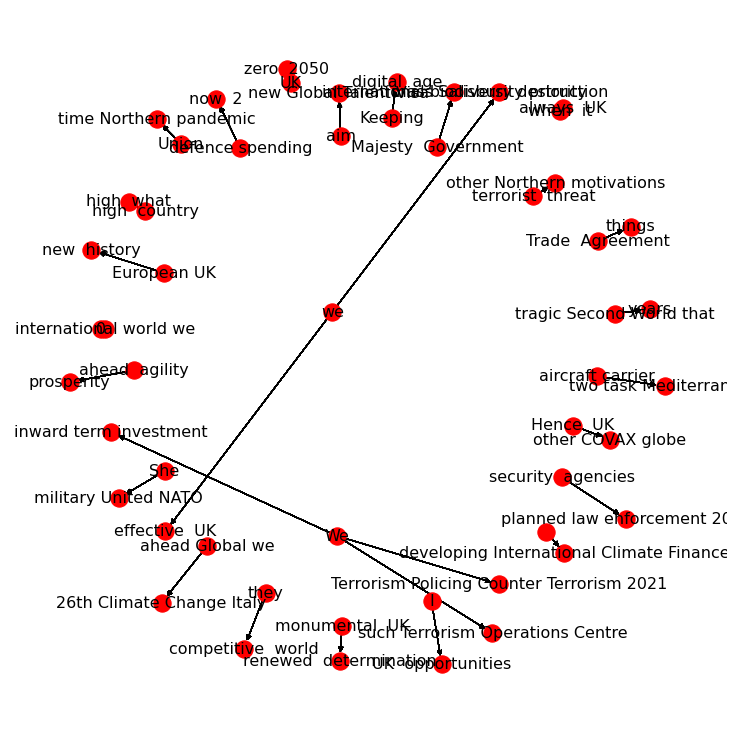

In [ ]:
plt.figure(figsize=(10,10))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='red', edge_cmap=plt.cm.Blues, pos = pos, font_size=16)
plt.show()

Creating subgraphs to segement on countries, events, organisations

Countries

In [ ]:
# Segement data
keywords_2021_GPE = ['UK', 'Scotland', 'Wales', 'Northern Ireland', 'Salisbury']
searched_keywords_2021_GPE = '|'.join(keywords_2021_GPE)
# Filter
text_2021_filter_GPE = text_2021[text_2021["sentence"].str.contains(searched_keywords_2021_GPE)]
text_2021_filter_GPE
# 1216 sentences

,sentence
2,Thanks to the fortitude of the British people ...
5,Hence the UK has joined other countries in th...
6,"Having left the European Union, the UK has sta..."
10,My vision for the UK in 2030 sets high ambitio...
11,"The Union between England, Scotland, Wales an..."
...,...
3316,point plan for a green industrial revolution b...
3318,The UK will remain a world leader in internat...
3321,British leadership in the world in 20212021 w...
3322,In 2021 the aircraft carrier HMS Queen Elizab...


100%|██████████| 1216/1216 [00:13<00:00, 87.02it/s]


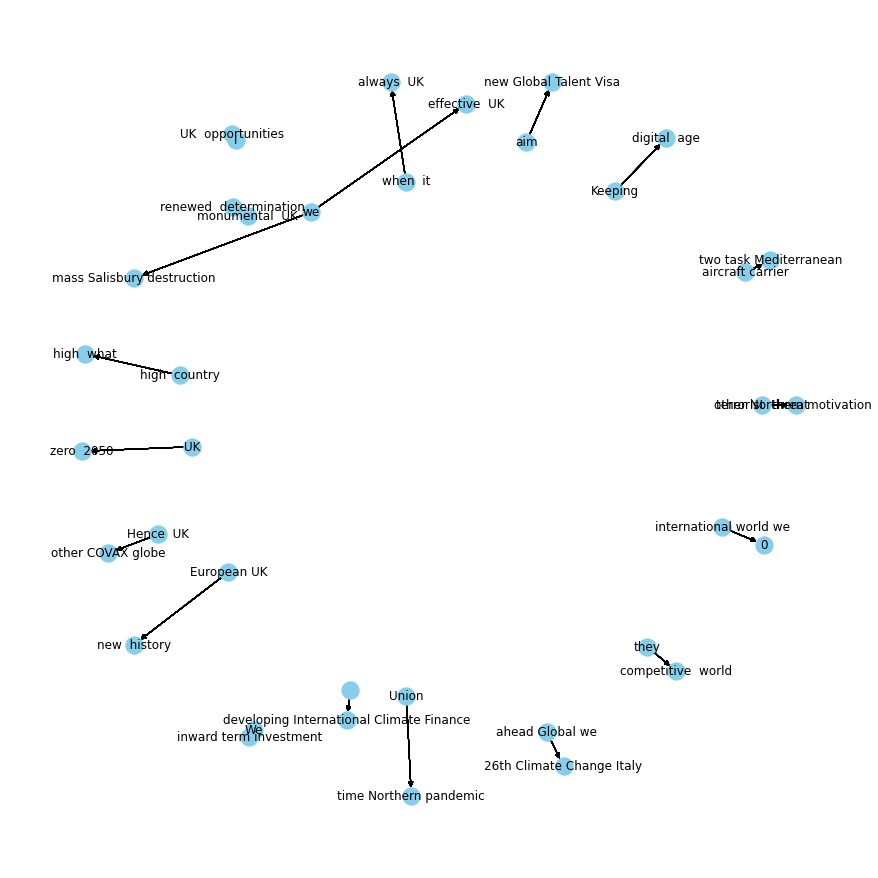

In [ ]:
# Get entity pairs
entity_pairs_2021_GPE = []

for i in tqdm(text_2021_filter_GPE["sentence"]):
  entity_pairs_2021_GPE.append(get_entities(i))

# Get relations
relations_2021_GPE = [get_relation(i) for i in tqdm(text_2021_filter_GPE['sentence'])]
tqdm._instances.clear()
# Subject
source_2021_GPE = [i[0] for i in entity_pairs_2021_GPE]
# Object
target_2021_GPE = [i[1] for i in entity_pairs_2021_GPE]
# Create df
kg_df_2021_GPE = pd.DataFrame({'source':source_2021_GPE, 'target':target_2021_GPE, 'edge':relations_2021_GPE})
# Create graph
G_2021_GPE =nx.from_pandas_edgelist(kg_df_2021_GPE, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
# Graph
pos = nx.spring_layout(G_2021_GPE)
nx.draw(G_2021_GPE, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

Organisations

In [ ]:
# Keywords
keywords_2021_ORG = ['the Integrated Review','the European Union', 'EU', 'The Union between England','NATO', 
                     'Counter Terrorism Policing', 'the Counter Terrorism Operations Centre', 'the National Cyber Force']
searched_keywords_2021_ORG = '|'.join(keywords_2021_ORG)
# Filter
text_2021_filter_ORG = text_2021[text_2021["sentence"].str.contains(searched_keywords_2021_ORG)]
text_2021_filter_ORG
# 512 rows

100%|██████████| 512/512 [00:05<00:00, 98.39it/s] 


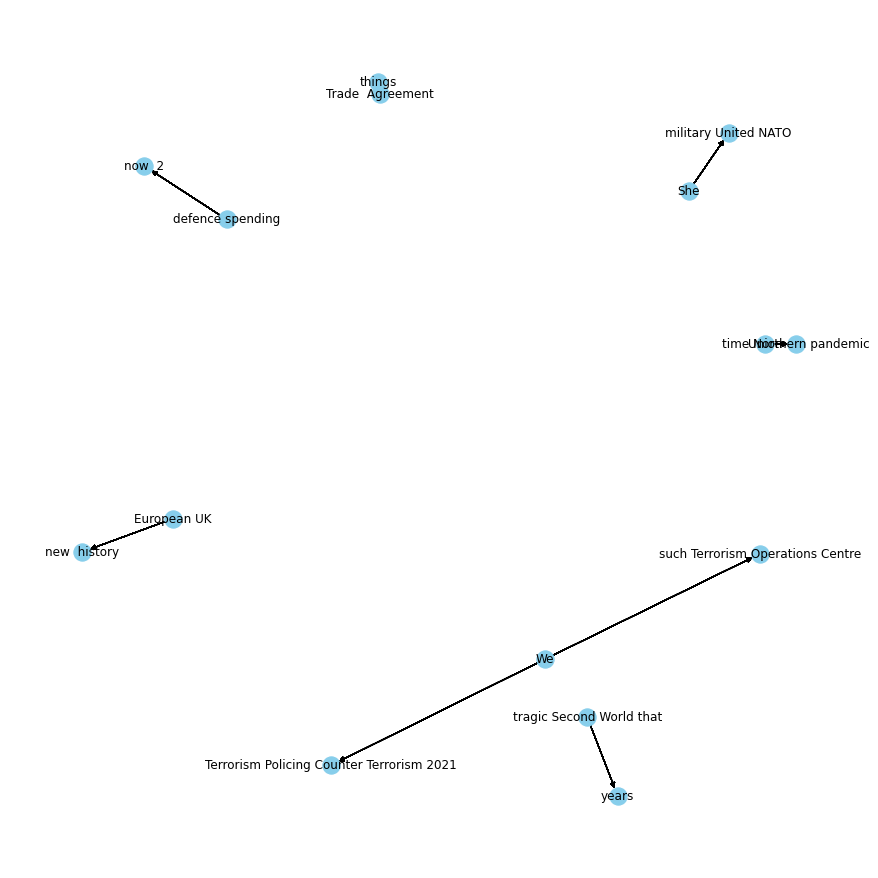

In [ ]:
# Get entity pairs
entity_pairs_2021_ORG = []

for i in tqdm(text_2021_filter_ORG["sentence"]):
  entity_pairs_2021_ORG.append(get_entities(i))

#entity_pairs_2010_ORG[10:20]
# Get relations
relations_2021_ORG = [get_relation(i) for i in tqdm(text_2021_filter_ORG['sentence'])]
tqdm._instances.clear()
# Subject
source_2021_ORG = [i[0] for i in entity_pairs_2021_ORG]
# Object
target_2021_ORG = [i[1] for i in entity_pairs_2021_ORG]
# Create df
kg_df_2021_ORG = pd.DataFrame({'source':source_2021_ORG, 'target':target_2021_ORG, 'edge':relations_2021_ORG})
# Create graph
G_2021_ORG =nx.from_pandas_edgelist(kg_df_2021_ORG, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
# Graph
pos = nx.spring_layout(G_2021_ORG)
nx.draw(G_2021_ORG, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

Date

In [ ]:
# Keywords
keywords_2021_DATE = ['early 2020', 'years', 'the years ahead', 'three years', '2017', '2025', '2030', '2021', '2050']
searched_keywords_2021_DATE = '|'.join(keywords_2021_DATE)
# Filter
text_2021_filter_DATE = text_2021[text_2021["sentence"].str.contains(searched_keywords_2021_DATE)]
text_2021_filter_DATE
# 768

100%|██████████| 768/768 [00:09<00:00, 82.86it/s]


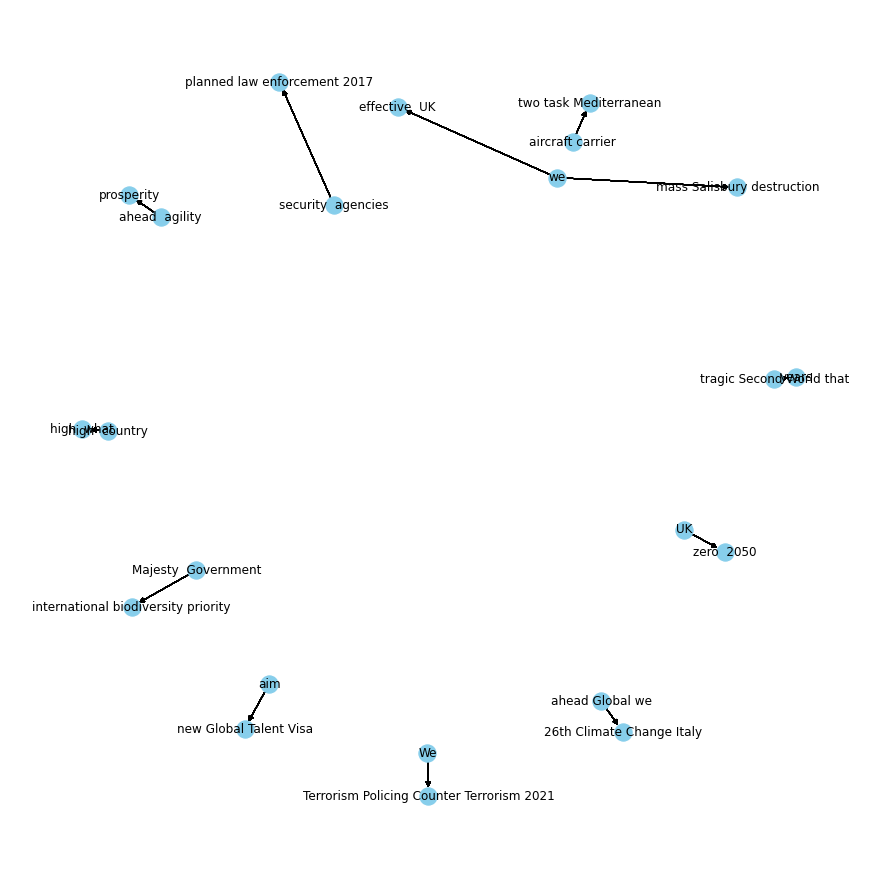

In [ ]:
# Get entity pairs
entity_pairs_2021_DATE = []

for i in tqdm(text_2021_filter_DATE["sentence"]):
  entity_pairs_2021_DATE.append(get_entities(i))

#entity_pairs_2010_ORG[10:20]
# Get relations
relations_2021_DATE = [get_relation(i) for i in tqdm(text_2021_filter_DATE['sentence'])]
tqdm._instances.clear()
# Subject
source_2021_DATE = [i[0] for i in entity_pairs_2021_DATE]
# Object
target_2021_DATE = [i[1] for i in entity_pairs_2021_DATE]
# Create df
kg_df_2021_DATE = pd.DataFrame({'source':source_2021_DATE, 'target':target_2021_DATE, 'edge':relations_2021_DATE})
# Create graph
G_2021_DATE =nx.from_pandas_edgelist(kg_df_2021_DATE, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
# Graph
pos = nx.spring_layout(G_2021_DATE)
nx.draw(G_2021_DATE, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()